In [11]:
import pandas as pd
from datasets import load_from_disk

In [3]:
resnet_df = pd.read_csv("results/resnet_gradcam_06_results.csv")
resnet_adv_df = pd.read_csv("results/resnet_adv_gradcam_06_results.csv")
densenet_df = pd.read_csv("results/densenet_gradcam_06_results.csv")
densenet_adv_df = pd.read_csv("results/densenet_adv_gradcam_06_results.csv")
effnet_df = pd.read_csv("results/efficienet_gradcam_06_results.csv")
effnet_adv_df = pd.read_csv("results/efficienet_adv_gradcam_06_results.csv")
mobilenet_df = pd.read_csv("results/mobilenet_gradcam_06_results.csv")
mobilenet_adv_df = pd.read_csv("results/mobilenet_adv_gradcam_06_results.csv")
vggnet_df = pd.read_csv("results/vggnet_gradcam_06_results.csv")
vggnet_adv_df = pd.read_csv("results/vggnet_adv_gradcam_06_results.csv")


In [5]:
results_df = resnet_df.copy()
results_df['resnet_adv_iou'] = resnet_adv_df["resnet_adv_iou"]
results_df["densenet_iou"] = densenet_df["densenet_iou"]
results_df["densenet_adv_iou"] = densenet_adv_df["densenet_adv_iou"]
results_df["effnet_iou"] = effnet_df["efficientnet_iou"]
results_df["effnet_adv_iou"] = effnet_adv_df["efficientnet_adv_iou"]
results_df["mobilenet_iou"] = mobilenet_df["mobilenet_iou"]
results_df["mobilenet_adv_iou"] = mobilenet_adv_df["mobilenet_adv_iou"]
results_df["vggnet_iou"] = vggnet_df["vggnet_iou"]
results_df["vggnet_adv_iou"] = vggnet_adv_df["vggnet_adv_iou"]

In [15]:
models = ["resnet", "resnet_adv", "densenet", "densenet_adv", "efficientnet", "efficientnet_adv", "mobilenet", "mobilenet_adv", "vggnet", "vggnet_adv"]

In [ ]:
results_df['resnet_bbox'] = resnet_df["cam_bboxes"]
results_df['resnet_adv_bbox'] = resnet_adv_df["cam_bboxes"]
results_df["densenet_bbox"] = densenet_df["cam_bboxes"]
results_df["densenet_adv_bbox"] = densenet_adv_df["cam_bboxes"]
results_df["effnet_bbox"] = effnet_df["cam_bboxes"]
results_df["effnet_adv_bbox"] = effnet_adv_df["cam_bboxes"]
results_df["mobilenet_bbox"] = mobilenet_df["cam_bboxes"]
results_df["mobilenet_adv_bbox"] = mobilenet_adv_df["cam_bboxes"]
results_df["vggnet_bbox"] = vggnet_df["cam_bboxes"]
results_df["vggnet_adv_bbox"] = vggnet_adv_df["cam_bboxes"]
# results_df.drop(columns = ["cam_bboxes"], inplace = True)

KeyError: "['cam_bboxes'] not found in axis"

In [22]:
results_df.to_csv("results/results.csv")

In [9]:
def draw_bboxes_on_image(image_np, bboxes, color=(255, 0, 0), thickness=2):
    image_copy = (image_np * 255).astype(np.uint8).copy() if image_np.max() <= 1.0 else image_np.copy()

    # Ensure it's a list of bboxes
    if isinstance(bboxes[0], (int, float)):
        bboxes = [bboxes]

    for (x, y, w, h) in bboxes:
        cv2.rectangle(image_copy, (int(x), int(y)), (int(x + w), int(y + h)), color, thickness)
    return image_copy

In [12]:
dataset = load_from_disk("resized_oxford_pets_224")

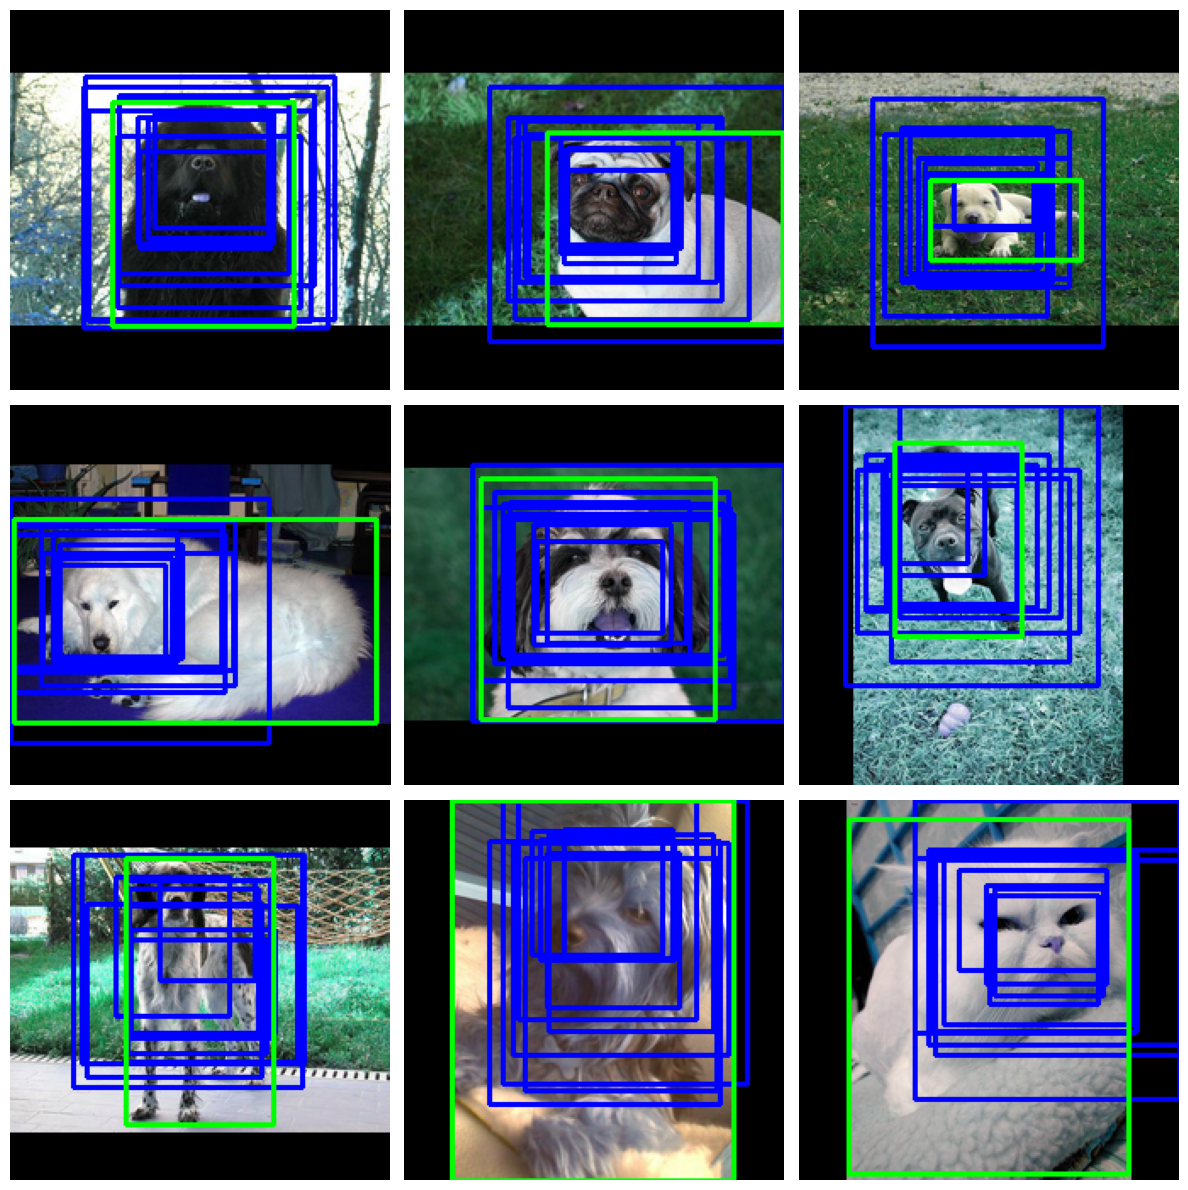

In [23]:
import ast
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk

# 1) load results.csv
results_df = pd.read_csv("results/results.csv")

# 2) load your HF dataset
dataset = load_from_disk("resized_oxford_pets_224")

# 3) helper: draw one or many [x,y,w,h] boxes on an image
def draw_bboxes_on_image(image_np, bboxes, color=(255, 0, 0), thickness=2):
    # ensure uint8 copy
    img = (image_np * 255).astype(np.uint8).copy() if image_np.max() <= 1.0 else image_np.copy()
    
    # parse different bbox‐formats:
    #  a) a string: literal list or list of lists → ast.literal_eval
    if isinstance(bboxes, str):
        bboxes = ast.literal_eval(bboxes)
    #  b) a single box [x,y,w,h]
    if isinstance(bboxes, (list, tuple)) and len(bboxes)==4 and all(isinstance(el, (int,float)) for el in bboxes):
        bboxes = [bboxes]
    #  c) now expect a list of boxes; otherwise skip
    if not isinstance(bboxes, (list, tuple)):
        return img
    
    for box in bboxes:
        if not (isinstance(box, (list, tuple)) and len(box)==4):
            continue
        x, y, w, h = map(int, box)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, thickness)
    return img

# 4) pick first 9 test items & define your models
indices = list(range(9))
models = [
    "resnet", "resnet_adv",
    "densenet", "densenet_adv",
    "effnet", "effnet_adv",
    "mobilenet", "mobilenet_adv",
    "vggnet", "vggnet_adv",
]

# 5) make 3×3 plot
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, idx in zip(axes.flatten(), indices):
    row = results_df.iloc[idx]
    data = dataset["test"][idx]
    
    # get raw image H×W×C
    if "image" in data:
        img = np.array(data["image"])
    elif "pixel_values" in data:
        pix = np.array(data["pixel_values"])
        img = pix.transpose(1,2,0) if pix.shape[0]==3 else pix
    else:
        raise KeyError("No image in dataset entry")
    
    # overlay each model's CAM bboxes in red
    for m in models:
        raw_bbs = row[f"{m}_bbox"]
        img = draw_bboxes_on_image(img, raw_bbs, color=(255, 0, 0), thickness=2)
    
    # overlay ground-truth in green
    gt = data.get("bbox") or data.get("bboxes") or data.get("annotations", {}).get("bbox")
    if gt is not None:
        # unwrap if list of boxes
        if isinstance(gt, (list, tuple)) and len(gt)>0 and isinstance(gt[0], (list, tuple)):
            gt = gt[0]
        img = draw_bboxes_on_image(img, gt, color=(0, 255, 0), thickness=2)
    
    # convert BGR→RGB for matplotlib
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis("off")

plt.tight_layout()
plt.show()

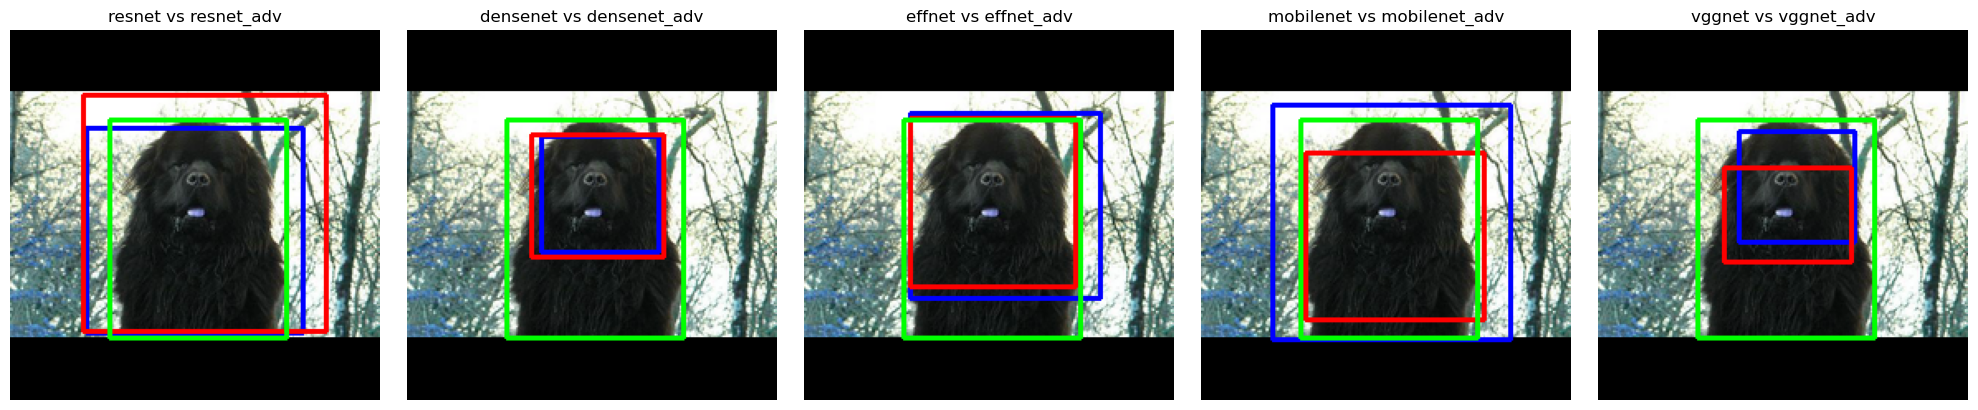

In [27]:
import ast
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk

# 1) load results & dataset
results_df = pd.read_csv("results/results.csv")
dataset = load_from_disk("resized_oxford_pets_224")

# 2) helper to draw one or many [x,y,w,h] boxes
def draw_bboxes_on_image(img_np, bboxes, color=(255,0,0), thickness=2):
    img = (img_np * 255).astype(np.uint8).copy() if img_np.max()<=1.0 else img_np.copy()
    if isinstance(bboxes, str):
        bboxes = ast.literal_eval(bboxes)
    if isinstance(bboxes, (list,tuple)) and len(bboxes)==4 and all(isinstance(v,(int,float)) for v in bboxes):
        bboxes = [bboxes]
    if isinstance(bboxes, (list,tuple)):
        for box in bboxes:
            if not (isinstance(box,(list,tuple)) and len(box)==4): continue
            x,y,w,h = map(int, box)
            cv2.rectangle(img, (x,y), (x+w,y+h), color, thickness)
    return img

# 3) define your 5 model pairs
pairs = [
    ("resnet",    "resnet_adv"),
    ("densenet",  "densenet_adv"),
    ("effnet",    "effnet_adv"),
    ("mobilenet", "mobilenet_adv"),
    ("vggnet",    "vggnet_adv"),
]

# 4) load the single image once
data0 = dataset["test"][0]
if "image" in data0:
    base_img = np.array(data0["image"])
else:
    pix = np.array(data0["pixel_values"])
    base_img = pix.transpose(1,2,0) if pix.shape[0]==3 else pix

# 5) make a 1×5 plot of the same image with different bboxes
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, (m, m_adv) in zip(axes, pairs):
    img = base_img.copy()

    # overlay base-model bbox in red
    raw = results_df.iloc[0][f"{m}_bbox"]
    img = draw_bboxes_on_image(img, raw, color=(255,0,0), thickness=2)

    # overlay adv-model bbox in blue
    raw_adv = results_df.iloc[0][f"{m_adv}_bbox"]
    img = draw_bboxes_on_image(img, raw_adv, color=(0,0,255), thickness=2)

    # overlay ground-truth in green
    gt = data0.get("bbox") or data0.get("bboxes") or data0.get("annotations",{}).get("bbox")
    if gt is not None:
        if isinstance(gt[0], (list,tuple)):
            gt = gt[0]
        img = draw_bboxes_on_image(img, gt, color=(0,255,0), thickness=2)

    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{m} vs {m_adv}")
    ax.axis("off")

plt.tight_layout()
plt.show()
